In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import random

In [2]:
gpus=tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
(train,_),(_,_)=tf.keras.datasets.fashion_mnist.load_data()
train.shape,train[0].max(),train[0].min()

((60000, 28, 28), 255, 0)

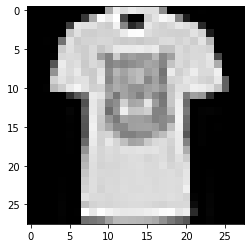

In [4]:
plt.imshow(train[random.randint(0,59999)],cmap='gray')
plt.show()

In [5]:
train=(train/255.0).astype('float32')
train[0].min(),train[0].max()

(0.0, 1.0)

In [6]:
def show_images(images):
    if len(images.shape)==4:
        images=np.squeeze(images)
    fig=plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for idx in range(images.shape[0]):
        plt.subplot(4,8,idx+1)
        plt.imshow(images[idx],cmap='gray')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

def show_generated_images():
    noise=np.random.randn(32,128,1)
    images=generator.predict(noise,verbose=0)
    show_images(images)

def get_figure():
    noise=np.random.randn(32,128)
    images=generator.predict(noise,verbose=0)
    images=np.squeeze(images)
    fig=plt.figure()
    fig.set_figwidth(20)
    fig.set_figheight(10)
    for idx in range(images.shape[0]):
        plt.subplot(4,8,idx+1)
        plt.imshow(images[idx],cmap='gray')
        plt.axis("off")
    plt.tight_layout()
    return fig

In [7]:
train_data=tf.data.Dataset.from_tensor_slices(train)
train_data=train_data.cache()
train_data=train_data.shuffle(train.shape[0])
train_data=train_data.batch(128)
train_data=train_data.prefetch(64)

In [8]:
train_iterator=train_data.as_numpy_iterator()

In [9]:
train_iterator.next().shape,train_iterator.next().min(),train_iterator.next().max()

((128, 28, 28), 0.0, 1.0)

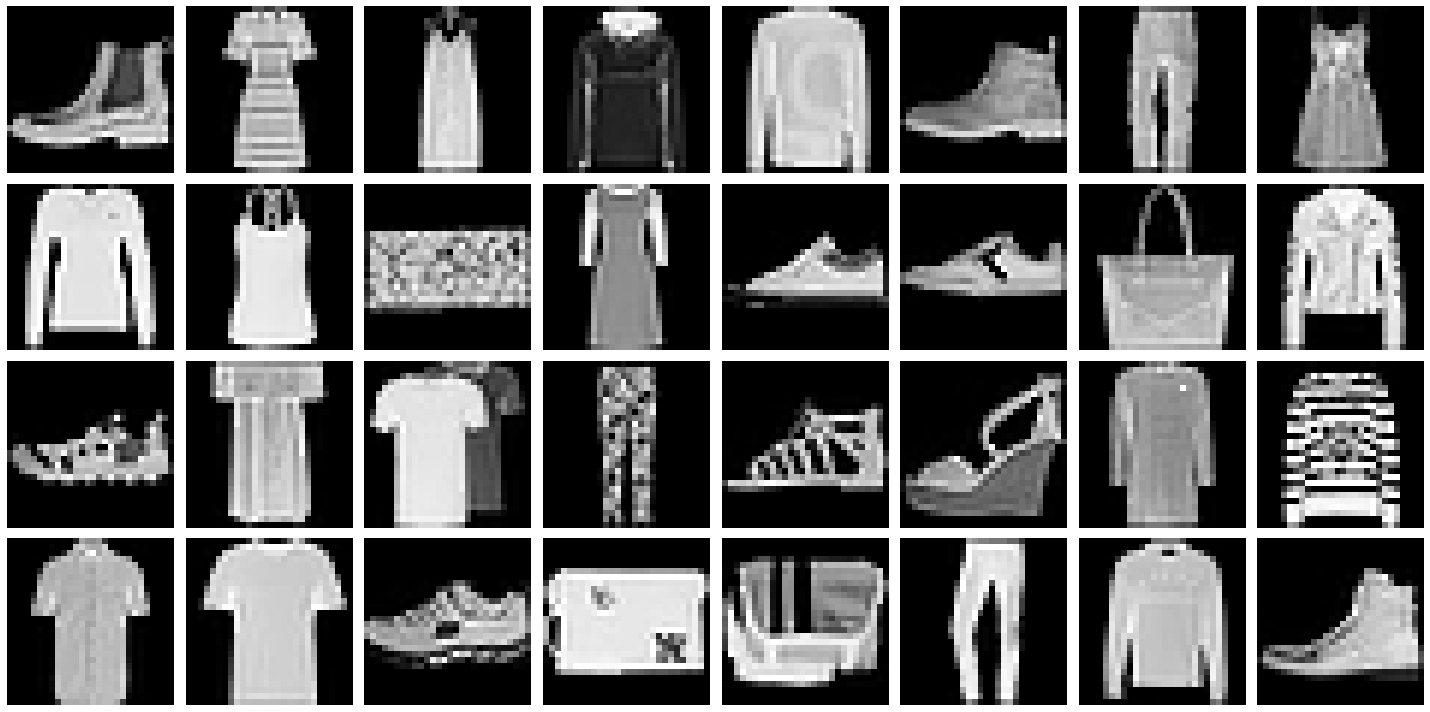

In [10]:
show_images(train_iterator.next()[:32])

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU,Dropout,Conv2DTranspose,BatchNormalization

In [12]:
def build_generator():
    model=Sequential()

    model.add(Dense(7*7*128,input_shape=(128,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(.2))
    model.add(Reshape((7,7,128)))

    model.add(Conv2DTranspose(64,(4,4),2,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(.2))

    model.add(Conv2DTranspose(1,(4,4),2,padding='same',activation='sigmoid'))

    return model

In [13]:
generator=build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       131136    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

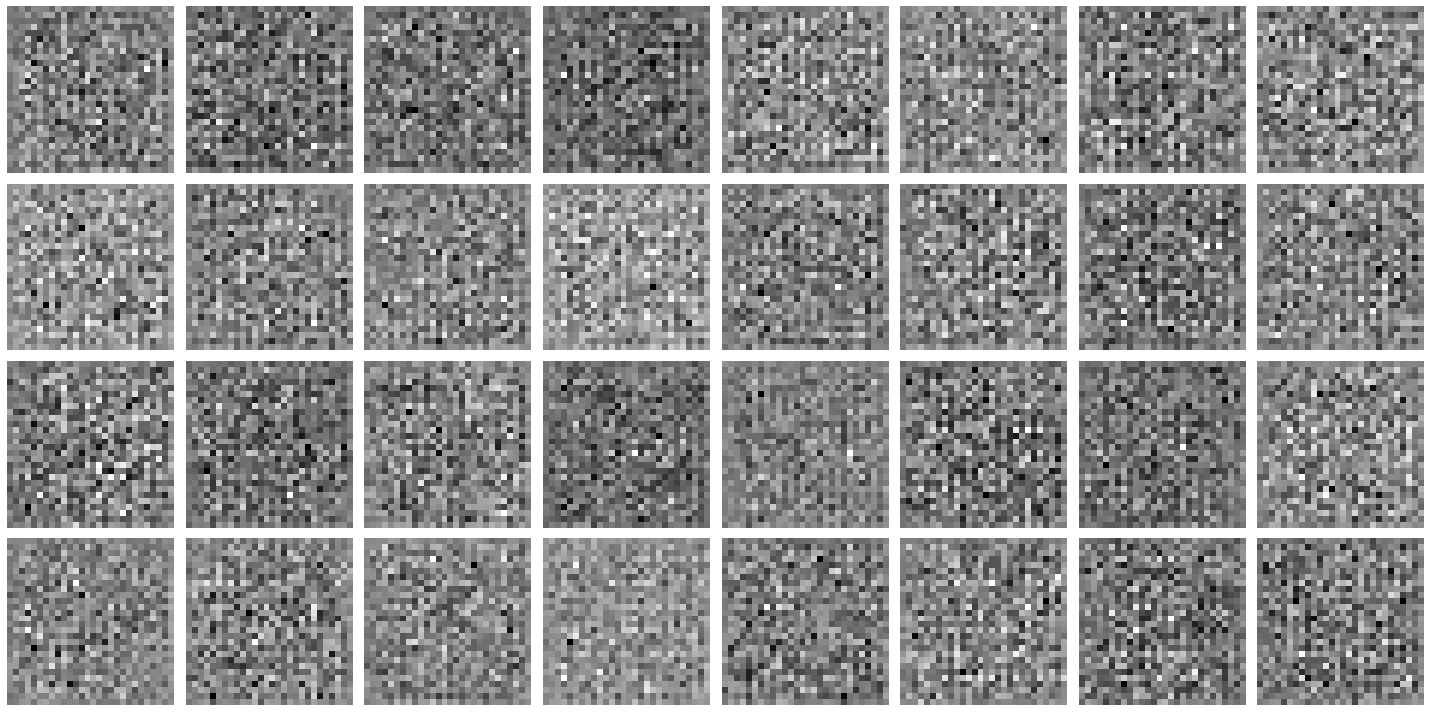

In [14]:
show_generated_images()

In [15]:
def build_discriminator():
    model=Sequential()

    model.add(Conv2D(64,(4,4),1,padding='same',input_shape=(28,28,1)))
    model.add(LeakyReLU(.2))

    model.add(Conv2D(128,(4,4),2,padding='same'))
    model.add(LeakyReLU(.2))

    model.add(Flatten())

    model.add(Dense(1,activation='sigmoid'))
    return model

In [16]:
discriminator=build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1088      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       131200    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 157,377
Trainable params: 157,377
Non-tr

In [17]:
discriminator(train_iterator.next()[:3],training=False),discriminator(generator(np.random.randn(3,128,1)),training=False)

(<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.5094368],
        [0.5123778],
        [0.513799 ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 1), dtype=float32, numpy=
 array([[0.5245724],
        [0.5243466],
        [0.5244568]], dtype=float32)>)

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [19]:
# ---------------- LOAD PRE-TRAINED MODEL ---------------------

generator=tf.keras.models.load_model(os.path.join('models','generator.h5'))
discriminator=tf.keras.models.load_model(os.path.join('models','discriminator.h5'))

In [20]:
generator_opt=Adam(1e-3)
discriminator_opt=Adam(1e-4)

generator_loss=BinaryCrossentropy()
discriminator_loss=BinaryCrossentropy()

In [21]:
from tensorflow.keras import Model

In [22]:
class FashionGan(Model):
    def __init__(self,generator,discriminator,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.generator=generator
        self.discriminator=discriminator
    
    def compile(self,generator_opt,discriminator_opt,generator_loss,discriminator_loss,*args,**kwargs):
        super().compile(*args,**kwargs)
        self.generator_opt=generator_opt
        self.discriminator_opt=discriminator_opt
        self.generator_loss=generator_loss
        self.discriminator_loss=discriminator_loss

    def train_step(self,batch):
        fake_images=self.generator(tf.random.normal((128,128,1)),training=False)
        real_images=batch

        with tf.GradientTape() as d_tape:
            yhat_real=self.discriminator(real_images,training=True)
            yhat_fake=self.discriminator(fake_images,training=True)
            yhat_realfake=tf.concat([yhat_real,yhat_fake],axis=0)
            
            y_realfake=tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.discriminator_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.discriminator_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            predicted_labels = self.discriminator(gen_images, training=False)

            total_g_loss = self.generator_loss(tf.zeros_like(predicted_labels), predicted_labels)
        
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.generator_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {'d_loss':total_d_loss,'g_loss':total_g_loss}

In [23]:
fashiongan=FashionGan(generator,discriminator)
fashiongan.compile(generator_opt,discriminator_opt,generator_loss,discriminator_loss)

In [24]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import pandas as pd

In [25]:
class ModelMonitor(Callback):
    def __init__(self,num_images=1,latent_dim=128):
        self.num_images=num_images
        self.latent_dim=latent_dim
    
    def on_epoch_end(self,epoch,logs=tf.keras.callbacks.TensorBoard(log_dir='logs')):
        generated_images=generator(np.random.randn(self.num_images,self.latent_dim,1),training=False)
        generated_images=(generated_images*255)
        generated_images=tf.cast(generated_images,dtype=np.int32)
        for i in range(self.num_images):
            img=array_to_img(generated_images[i])
            img.save(os.path.join('generated',f'generated_img_{epoch}.{i}.jpg'))

In [77]:
history=fashiongan.fit(train_data,epochs=500,callbacks=[ModelMonitor()])

469/469 [==============================] - 494s 1s/step - d_loss: 0.3166 - g_loss: 0.2827


In [43]:
# ---------- CAUTION -------------

# df=pd.DataFrame(history.history)
# df.to_csv('model_loss.csv',index=False)

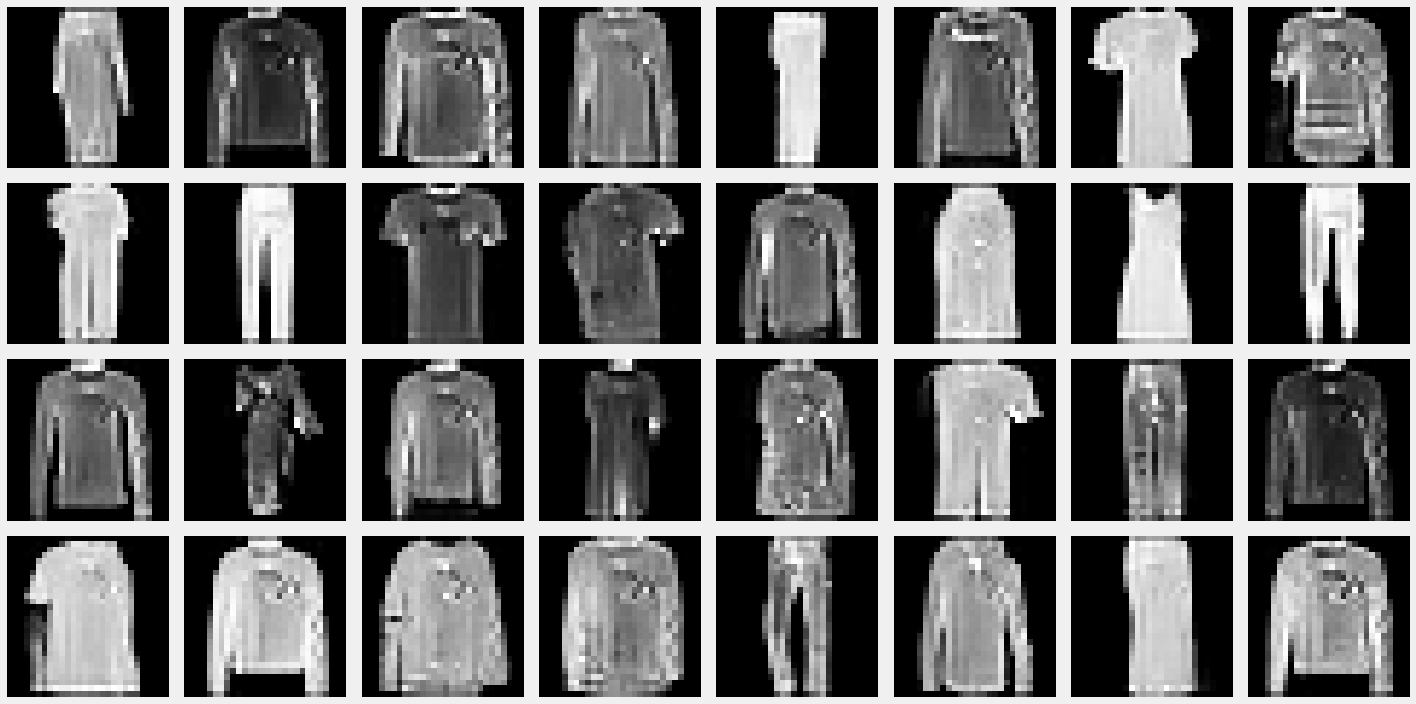

In [42]:
show_generated_images()

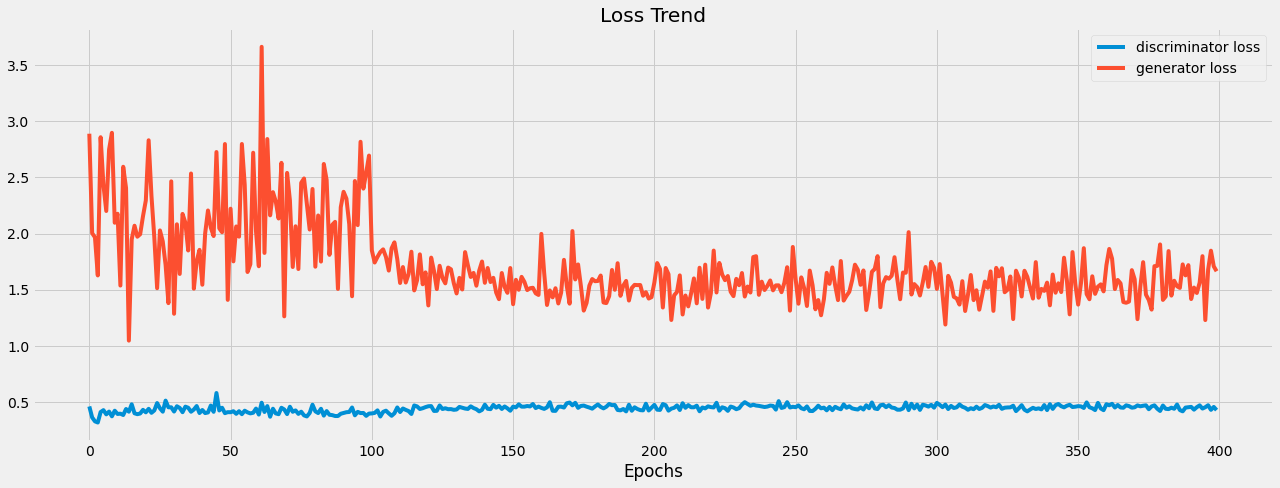

In [27]:
df=pd.read_csv('model_loss.csv')
plt.style.use('fivethirtyeight')
plt.figure(figsize=(18,7))
plt.plot(df['d_loss'],label='discriminator loss')
plt.plot(df['g_loss'],label='generator loss')
plt.xlabel('Epochs')
plt.title('Loss Trend')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# ------------!!!  CAUTION  !!!---------------------

# if not os.path.exists('metadata'):
#     os.mkdir('metadata')
# generator.save('./metadata/')
# discriminator.save('./metadata/')
# if not os.path.exists('models'):
#     os.mkdir('models')
# tf.keras.models.save_model(generator,os.path.join('models','generator.h5'))
# tf.keras.models.save_model(discriminator,os.path.join('models','discriminator.h5'))